# CIb LSx: ONTRAM 3D CNN
## Outcome: stroke

### Load dependencies

In [1]:
!python -V

Python 3.6.9


In [2]:
# !python -m pip install -U scikit-image

In [3]:
import os
import h5py
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scipy import ndimage
from sklearn import metrics
from sklearn import linear_model

# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical

# Own functions
from functions.plot_slices import plot_slices
from functions.ontram import ontram
from functions.fit_ontram import fit_ontram
from functions.fit_ontram_batches import fit_ontram_batches
from functions.plot_results import plot_results
from functions.methods import predict

2.4.0
2.4.0


### Config Variables

In [4]:
OUTPUT_VARIABLE = "stroke"
# OUTPUT_VARIABLE = "mrs"
N_ENSEMBLES = 5
N_FOLDS = 5

In [5]:
DIR = "/tf/notebooks/katrpe/"
OUTPUT_DIR = '{}results/stroke/ensemble/'.format(DIR)
MODEL_DIR = '{}results/stroke/ensemble/CIb/'.format(DIR)
INPUT_IMG = "{}data/dicom_3d_128x128x30.h5".format(DIR)
INPUT_TAB = "{}data/baseline_data_DWI_imputed.csv".format(DIR)

### Import images

In [6]:
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

In [7]:
with h5py.File(INPUT_IMG, "r") as h5:
    print(h5.keys())
    X = h5["X"][:]
    Y_pat = h5["stroke"][:]
    Y_img = h5["Y"][:]
    pat = decode_data(h5["pat"])[:]

<KeysViewHDF5 ['X', 'Y', 'pat', 'path', 'stroke']>


In [8]:
print(X.shape, Y_pat.shape, Y_img.shape, len(pat))

(497, 128, 128, 30) (497,) (497, 30) 497


In [9]:
print(X.shape, X.min(), X.max(), X.mean(), X.std())

(497, 128, 128, 30) 0 31230 50.134894023974574 131.06881648692314


### Preprocessing
- standardize each patient to 0 mean, 1 variance

In [10]:
def standardize(array):
    mean = np.mean(array)
    sd = np.std(array)
    standardized = (array - mean) / sd
    return standardized

In [11]:
X = np.array([standardize(x) for x in X])
X = np.expand_dims(X, axis = 4)

In [12]:
print(X.shape, X.min(), X.max(), X.mean(), X.std())

(497, 128, 128, 30, 1) -0.7185620314211808 27.025452485896956 1.2807401759592685e-18 1.0000000000000004


### Import tabular data

In [13]:
INPUT_TAB

'/tf/notebooks/katrpe/data/baseline_data_DWI_imputed.csv'

In [14]:
dat = pd.read_csv(INPUT_TAB, sep = ',')
dat.head(3)

,p_id,age,sex,mrs_before,nihss_baseline,stroke_before,tia_before,rf_hypertonia,rf_diabetes,rf_hypercholesterolemia,rf_smoker,rf_atrial_fibrillation,rf_chd,event,mrs_3months
0,1,34.0,male,1,1,no,no,no,no,yes,no,no,no,Stroke,1.0
1,2,46.0,male,1,8,no,no,no,no,yes,no,no,no,Stroke,1.0
2,3,81.0,male,1,16,no,no,yes,yes,yes,yes,yes,no,Stroke,0.0


In [15]:
# change values to numbers
dat = dat.replace('no', 0)
dat = dat.replace('yes', 1)
dat.sex = dat.sex.replace('female', 1)
dat.sex = dat.sex.replace('male', 0)
dat.event = dat.event.replace('Stroke', 1)
dat.event = dat.event.replace('TIA', 0)
dat.p_id =[format(id, '03d') for id in dat.p_id]
dat.head(3)

,p_id,age,sex,mrs_before,nihss_baseline,stroke_before,tia_before,rf_hypertonia,rf_diabetes,rf_hypercholesterolemia,rf_smoker,rf_atrial_fibrillation,rf_chd,event,mrs_3months
0,001,34.0,0,1,1,0,0,0,0,1,0,0,0,1,1.0
1,002,46.0,0,1,8,0,0,0,0,1,0,0,0,1,1.0
2,003,81.0,0,1,16,0,0,1,1,1,1,1,0,1,0.0


In [16]:
# Variables we have
dat.columns

Index(['p_id', 'age', 'sex', 'mrs_before', 'nihss_baseline', 'stroke_before',
       'tia_before', 'rf_hypertonia', 'rf_diabetes', 'rf_hypercholesterolemia',
       'rf_smoker', 'rf_atrial_fibrillation', 'rf_chd', 'event',
       'mrs_3months'],
      dtype='object')

(array([154., 343.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

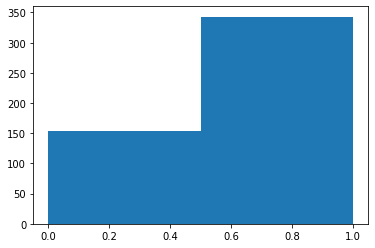

In [17]:
# define mRS binary 
dat["mrs_3months_binary"] = 1
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 0
plt.hist(dat.event, bins = 2)

In [18]:
# match tabular data to image data
X_tab = np.zeros((X.shape[0], 12))
Y_mrs = np.zeros((X.shape[0]))
Y_pat = np.zeros((dat.shape[0]))
for i, p in enumerate(pat):
    k = np.where(dat.p_id.values == p)[0][0]
    dat_tmp = dat.iloc[k]
    X_tab[i,:] = np.array([dat_tmp.age, dat_tmp.sex, dat_tmp.mrs_before, dat_tmp.nihss_baseline, 
                           dat_tmp.stroke_before, dat_tmp.tia_before, dat_tmp.rf_hypertonia, 
                           dat_tmp.rf_diabetes, dat_tmp.rf_hypercholesterolemia, dat_tmp.rf_smoker, 
                           dat_tmp.rf_atrial_fibrillation, dat_tmp.rf_chd])
    Y_mrs[i] = dat_tmp.mrs_3months_binary
    Y_pat[i] = dat_tmp.event
X_tab

array([[34. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [46. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [81. ,  0. ,  1. , ...,  1. ,  1. ,  0. ],
       ...,
       [61. ,  1. ,  1. , ...,  1. ,  0. ,  0. ],
       [59. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [74.3,  0. ,  2. , ...,  0. ,  0. ,  0. ]])

In [19]:
if OUTPUT_VARIABLE == "stroke":
    Y = Y_pat
elif OUTPUT_VARIABLE == "mrs":
    Y = Y_mrs
else:
    raise ValueError("unknown OUTPUT_VARIABLE: {}".format(OUTPUT_VARIABLE))

### Augmentation

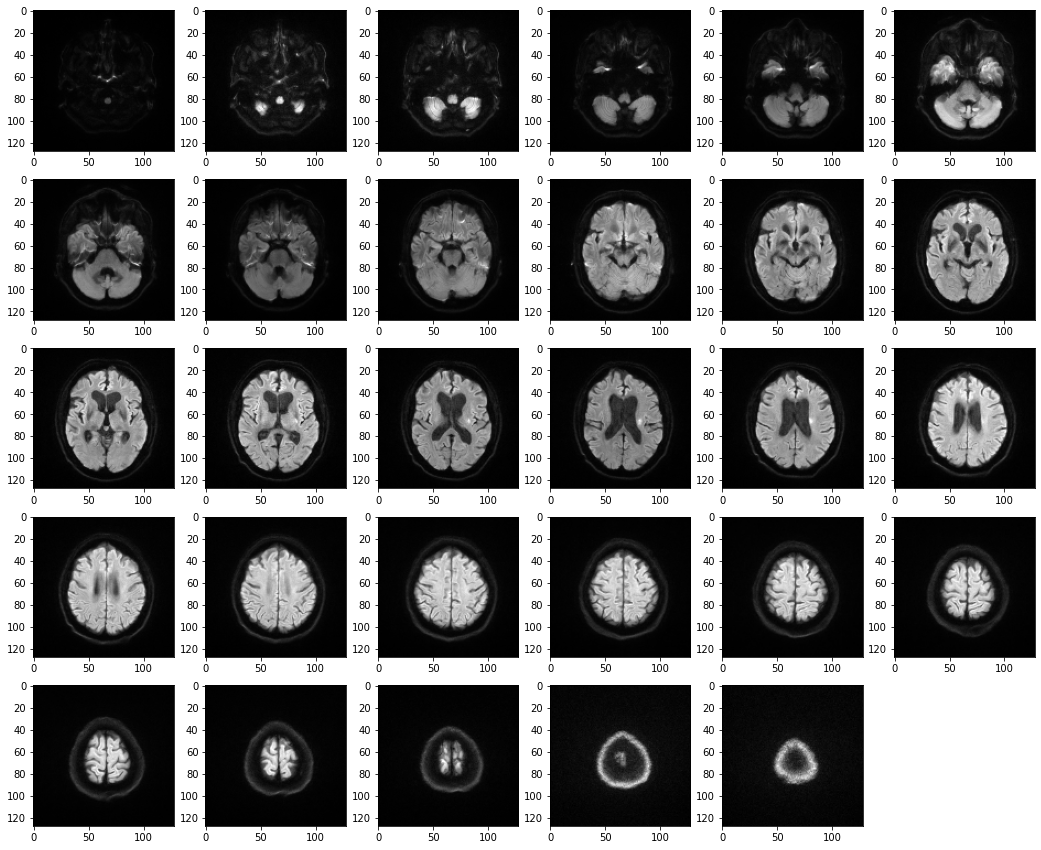

In [20]:
j = 10
plot_slices(X[j], pat, "axial", modality = "DWI")

In [21]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

In [22]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

In [23]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

In [24]:
# flip
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
    return X_im

In [25]:
# smoothing
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

In [26]:
# combine augmentation functions:
def augment_batch(X_batch):
    X_batch_aug = np.empty_like(X_batch)
    for i in range(X_batch.shape[0]):
        im = X_batch[i]
        im = random_zoom3d(im, 0.7, 1.4)
        im = random_rotate3d(im, -30, 30, -10, 10, -10, 10)
        im = random_shift3d(im, -20, 20, -20, 20, -5, 5)
        im = random_flip3d(im)
        im = random_gaussianfilter3d(im, 0.2)
        X_batch_aug[i] = im
    return X_batch_aug

### Define train validation test set

In [27]:
## get TIA = 0 and stroke = 1 indices
idx_0 = np.where(Y == 0)
idx_1 = np.where(Y == 1)
print("{} TIA patients".format(len(idx_0[0])))
print("{} stroke patients".format(len(idx_1[0])))

## shuffle indices
np.random.seed(2021)
np.random.shuffle(idx_0[0])
np.random.shuffle(idx_1[0])

## split indices into 5 parts
splits_0 = np.array_split(idx_0[0], N_FOLDS)
splits_1 = np.array_split(idx_1[0], N_FOLDS)

## define chosen splits for each fold
test_folds = [0, 1, 2, 3, 4]
valid_folds = [1, 2, 3, 4, 0]
train_folds = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 4]] ## remove these splits for training data

154 TIA patients
343 stroke patients


### Define models for image data
### Complex intercept Linear Shift
Train with
- imaging and tabular data
- imaging data as complex intercept
- tabular data as linear shift
- outcome = stroke
- Ensemble with 5 Models
- 5-Fold CV
- "Warmstart"

In [28]:
# linear shift
def linear_shift_x(x):
    in_ = keras.Input(shape = x.shape[1:], name = 'x_in')
    out_ = layers.Dense(1, activation = 'linear',
                        use_bias = False, name = 'x_out')(in_)
    nn_x = keras.Model(inputs = in_, outputs = out_)
    return nn_x

# complex shift for image
def complex_intercept_b(input_shape, output_shape, input_name, activation = "linear"):
    
    initializer = keras.initializers.HeNormal(seed = 2802)
    
    in_ = keras.Input(shape = input_shape, name = input_name)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', 
                             activation = 'relu', kernel_initializer = initializer)(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 1))(x) # evtl (2,2,2)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', 
                             activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', 
                             activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', 
                             activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same', 
                             activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    
    h = layers.Dense(output_shape, activation = activation)(x) # activation = linear
    
    out_ = layers.Lambda(lambda x: x * 0.1)(h) # get rid of too large values for h
    
    nn_im = keras.Model(inputs = in_, outputs = out_)
    return nn_im

logreg_model = linear_model.LogisticRegression(max_iter=1000)

### Train Models

In [ ]:
for fold in range(N_FOLDS):
    
    ## define train, test and validation splits
    test_idx = np.concatenate((splits_0[test_folds[fold]], splits_1[test_folds[fold]]), axis = None)
    valid_idx = np.concatenate((splits_0[valid_folds[fold]], splits_1[valid_folds[fold]]), axis = None)

    train_0 = np.delete(splits_0, train_folds[fold], 0)
    train_0 = [item for sublist in train_0 for item in sublist]
    
    train_1 = np.delete(splits_1, train_folds[fold], 0)
    train_1 = [item for sublist in train_1 for item in sublist]
    
    train_idx = np.concatenate((train_0, train_1), axis = None)
    
    X_im_train = X[train_idx]
    X_im_test = X[test_idx]
    X_im_valid = X[valid_idx]
    
    X_tab_train = X_tab[train_idx]
    X_tab_test = X_tab[test_idx]
    X_tab_valid = X_tab[valid_idx]
    
    Y_train = Y[train_idx]
    Y_test = Y[test_idx]
    Y_valid = Y[valid_idx] 
    
    logreg_model.fit(X_tab_train, Y_train)
    LSx_weights = logreg_model.coef_.reshape(12, 1)
    
    Y_train = to_categorical(Y_train)
    Y_valid = to_categorical(Y_valid)
    Y_test = to_categorical(Y_test)

    for run in range(N_ENSEMBLES):
    
        ## create output directory
        folder_name = "CIb_LSx/fold_{}/run_{}/".format(fold, run)
        if not os.path.exists(OUTPUT_DIR + folder_name):
            os.makedirs(OUTPUT_DIR + folder_name)
       
        print("training fold {}/{}, run {}/{}".format(fold+1, N_FOLDS, run+1, N_ENSEMBLES))
    
        ## compile and fit model
        nn_bl = complex_intercept_b(X_im_train.shape[1:], Y_train.shape[1]-1, "bl_in", "linear")
        ## load weights from trained model in CIb, same fold, same run
        nn_bl.load_weights('{}fold_{}/best_model_run{}.hdf5'.format(MODEL_DIR, fold, run))
        
        nn_x = linear_shift_x(X_tab_train)
        ## set weights from logistic regression with corresponding fold + noise
        np.random.seed(1234 + run)
        noise = np.random.normal(loc = 0, scale = 0.1, size = 12)
        nn_x.set_weights([np.add(LSx_weights.flatten(), noise).reshape(12, 1)])
        
        ci_ls = ontram(nn_bl = nn_bl, nn_x = nn_x, response_varying = True)
        
        hist = fit_ontram(ci_ls,
                          y_train = Y_train,
                          x_train = X_tab_train,
                          x_train_im = X_im_train,
                          x_test = X_tab_valid,
                          x_test_im = X_im_valid, 
                          y_test = Y_valid,
                          batch_size = 32,
                          epochs = 200,
                          optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                          augment_batch = augment_batch,
                          balance_batches = True,
                          output_dir = OUTPUT_DIR + folder_name)

        ## save training loss and accuracy
        out = pd.DataFrame({'fold': fold,
                            'run': run,
                            'train_loss': hist["train_loss"], 
                            'train_acc': hist["train_acc"],
                            'test_loss': hist["test_loss"], 
                            'test_acc': hist["test_acc"]})
        if run == 0 and fold == 0:
            out.to_csv("{}CIb_LSx/ensemble_history.csv".format(OUTPUT_DIR), index = False)
        else:
            out.to_csv("{}CIb_LSx/ensemble_history.csv".format(OUTPUT_DIR), 
                       mode='a', header=False, index = False)

        ## save best model
        best_model = np.where(out.test_loss == np.min(out.test_loss))[0][0]
        print('best model run {}: {}'.format(run, best_model))
        ci_ls.model.load_weights('{}{}model-{:03d}.hdf5'.format(OUTPUT_DIR, folder_name, best_model))
        ci_ls.model.save_weights('{}CIb_LSx/fold_{}/best_model_run{}.hdf5'.format(OUTPUT_DIR, fold, run))
        
        # predict model
        pred = predict(ci_ls, bl = X_im_test, x = X_tab_test, y = Y_test)
        out = pd.DataFrame({'pid': np.array(pat)[test_idx],
                            'fold': fold,
                            'run': run,
                            'pred_prob_tia': pred["pdf"][:, 0],
                            'pred_prob_stroke': pred["pdf"][:, 1],
                            'pred_label_stroke': pred["response"],
                            'patient_label_tia': Y_test[:, 0],
                            'patient_label_stroke': Y_test[:, 1]})
        if run == 0 and fold == 0:
            out.to_csv("{}CIb_LSx/ensemble_predictions.csv".format(OUTPUT_DIR), index = False)
        else:
            out.to_csv("{}CIb_LSx/ensemble_predictions.csv".format(OUTPUT_DIR), 
                       mode='a', header=False, index = False)
            
        ## save model weights
        names = ['age', 'sex', 'mrs_before', 'nihss_baseline', 'stroke_before', 
                     'tia_before', 'rf_hypertonia', 'rf_diabetes', 'rf_hypercholesterolemia', 
                     'rf_smoker', 'rf_atrial_fibrillation', 'rf_chd']
        weights = np.array(pred['beta_w']).flatten()
        out = pd.DataFrame({'fold': fold,
                            'run': run,
                            'names': names,
                            'coef': weights})
        if run == 0 and fold == 0:
            out.to_csv("{}CIb_LSx/ensemble_weights.csv".format(OUTPUT_DIR), index = False)
        else:
            out.to_csv("{}CIb_LSx/ensemble_weights.csv".format(OUTPUT_DIR), 
                       mode='a', header=False, index = False)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


training fold 1/5, run 1/5
Epoch 000: Train loss: 1.0348, Train accuracy: 61.46%, Test loss: 0.6937, Test accuracy: 71.88%
Epoch 001: Train loss: 0.7594, Train accuracy: 65.62%, Test loss: 0.4835, Test accuracy: 76.04%
Epoch 002: Train loss: 0.5669, Train accuracy: 76.04%, Test loss: 0.4297, Test accuracy: 85.42%
Epoch 003: Train loss: 0.3851, Train accuracy: 84.38%, Test loss: 0.5106, Test accuracy: 87.50%
Epoch 004: Train loss: 0.2842, Train accuracy: 87.85%, Test loss: 0.5992, Test accuracy: 87.50%
Epoch 005: Train loss: 0.2532, Train accuracy: 89.93%, Test loss: 0.6095, Test accuracy: 87.50%
Epoch 006: Train loss: 0.3243, Train accuracy: 84.72%, Test loss: 0.5035, Test accuracy: 86.46%
Epoch 007: Train loss: 0.2549, Train accuracy: 88.89%, Test loss: 0.4306, Test accuracy: 90.62%
Epoch 008: Train loss: 0.2799, Train accuracy: 87.50%, Test loss: 0.4298, Test accuracy: 90.62%
Epoch 009: Train loss: 0.2657, Train accuracy: 88.19%, Test loss: 0.4526, Test accuracy: 89.58%
Epoch 010: Tr

In [ ]:
pred = pd.read_csv("{}CIb_LSx/ensemble_predictions.csv".format(OUTPUT_DIR))
pred.head(5)

In [ ]:
weights = pd.read_csv("{}CIb_LSx/ensemble_weights.csv".format(OUTPUT_DIR))
weights.head(5)

In [ ]:
hist = pd.read_csv("{}CIb_LSx/ensemble_history.csv".format(OUTPUT_DIR))
hist.head(5)